In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 100
batch_size = 8
loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.90)
input_path = '../../data/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


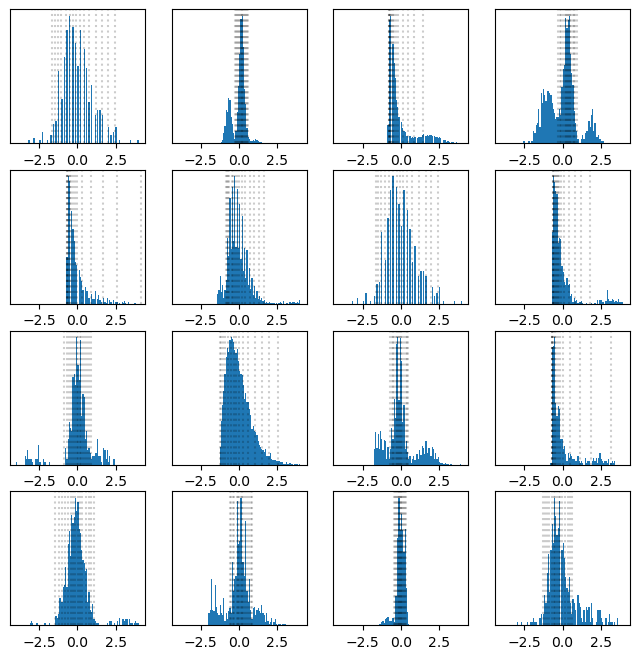

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [6]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [7]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [8]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [9]:
x_train.shape

(5000, 100, 1)

In [10]:
y_train.shape


(5000, 16)

In [11]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [12]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 49, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 64)            12352 

In [13]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/100


I0000 00:00:1716798915.618705   30524 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.19222, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 8s - loss: 0.3673 - val_loss: 0.1922 - 8s/epoch - 13ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.19222
625/625 - 3s - loss: 0.1833 - val_loss: 0.2022 - 3s/epoch - 4ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.19222 to 0.13668, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.1514 - val_loss: 0.1367 - 4s/epoch - 6ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.13668 to 0.10337, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1272 - val_loss: 0.1034 - 3s/epoch - 5ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.10337 to 0.09018, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.1116 - val_loss: 0.0902 - 3s/epoch - 5ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.09018
625/625 - 3s - loss: 0.1004 - val_loss: 0.0974 - 3s/epoch - 4ms/step
Epoch 7/100

Epoch 7: val_loss improved from 0.09018 to 0.07573, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0936 - val_loss: 0.0757 - 3s/epoch - 5ms/step
Epoch 8/100

Epoch 8: val_loss did not improve from 0.07573
625/625 - 2s - loss: 0.0862 - val_loss: 0.0780 - 2s/epoch - 4ms/step
Epoch 9/100

Epoch 9: val_loss did not improve from 0.07573
625/625 - 3s - loss: 0.0842 - val_loss: 0.0854 - 3s/epoch - 4ms/step
Epoch 10/100

Epoch 10: val_loss did not improve from 0.07573
625/625 - 3s - loss: 0.0795 - val_loss: 0.0793 - 3s/epoch - 4ms/step
Epoch 11/100

Epoch 11: val_loss did not improve from 0.07573
625/625 - 3s - loss: 0.0748 - val_loss: 0.0778 - 3s/epoch - 4ms/step
Epoch 12/100

Epoch 12: val_loss did not improve from 0.07573
625/625 - 3s - loss: 0.0732 - val_loss: 0.0762 - 3s/epoch - 4ms/step
Epoch 13/100

Epoch 13: val_loss improved from 0.07573 to 0.06609, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0684 - val_loss: 0.0661 - 3s/epoch - 5ms/step
Epoch 14/100

Epoch 14: val_loss improved from 0.06609 to 0.06206, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0658 - val_loss: 0.0621 - 3s/epoch - 5ms/step
Epoch 15/100

Epoch 15: val_loss improved from 0.06206 to 0.05974, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0633 - val_loss: 0.0597 - 3s/epoch - 5ms/step
Epoch 16/100

Epoch 16: val_loss improved from 0.05974 to 0.05504, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.0615 - val_loss: 0.0550 - 4s/epoch - 6ms/step
Epoch 17/100

Epoch 17: val_loss did not improve from 0.05504
625/625 - 3s - loss: 0.0599 - val_loss: 0.0701 - 3s/epoch - 4ms/step
Epoch 18/100

Epoch 18: val_loss did not improve from 0.05504
625/625 - 3s - loss: 0.0577 - val_loss: 0.0655 - 3s/epoch - 4ms/step
Epoch 19/100

Epoch 19: val_loss did not improve from 0.05504
625/625 - 3s - loss: 0.0559 - val_loss: 0.0691 - 3s/epoch - 4ms/step
Epoch 20/100

Epoch 20: val_loss did not improve from 0.05504
625/625 - 3s - loss: 0.0558 - val_loss: 0.0581 - 3s/epoch - 4ms/step
Epoch 21/100

Epoch 21: val_loss did not improve from 0.05504
625/625 - 3s - loss: 0.0526 - val_loss: 0.0568 - 3s/epoch - 4ms/step
Epoch 22/100

Epoch 22: val_loss improved from 0.05504 to 0.05489, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0515 - val_loss: 0.0549 - 3s/epoch - 5ms/step
Epoch 23/100

Epoch 23: val_loss did not improve from 0.05489
625/625 - 3s - loss: 0.0512 - val_loss: 0.0551 - 3s/epoch - 4ms/step
Epoch 24/100

Epoch 24: val_loss improved from 0.05489 to 0.05315, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.0497 - val_loss: 0.0532 - 4s/epoch - 7ms/step
Epoch 25/100

Epoch 25: val_loss did not improve from 0.05315
625/625 - 3s - loss: 0.0485 - val_loss: 0.0577 - 3s/epoch - 5ms/step
Epoch 26/100

Epoch 26: val_loss did not improve from 0.05315
625/625 - 3s - loss: 0.0472 - val_loss: 0.0575 - 3s/epoch - 4ms/step
Epoch 27/100

Epoch 27: val_loss did not improve from 0.05315
625/625 - 3s - loss: 0.0458 - val_loss: 0.0567 - 3s/epoch - 4ms/step
Epoch 28/100

Epoch 28: val_loss improved from 0.05315 to 0.05272, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0455 - val_loss: 0.0527 - 3s/epoch - 5ms/step
Epoch 29/100

Epoch 29: val_loss did not improve from 0.05272
625/625 - 2s - loss: 0.0439 - val_loss: 0.0531 - 2s/epoch - 4ms/step
Epoch 30/100

Epoch 30: val_loss improved from 0.05272 to 0.05138, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0431 - val_loss: 0.0514 - 3s/epoch - 5ms/step
Epoch 31/100

Epoch 31: val_loss improved from 0.05138 to 0.05059, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0415 - val_loss: 0.0506 - 3s/epoch - 5ms/step
Epoch 32/100

Epoch 32: val_loss did not improve from 0.05059
625/625 - 3s - loss: 0.0418 - val_loss: 0.0552 - 3s/epoch - 4ms/step
Epoch 33/100

Epoch 33: val_loss did not improve from 0.05059
625/625 - 2s - loss: 0.0402 - val_loss: 0.0512 - 2s/epoch - 4ms/step
Epoch 34/100

Epoch 34: val_loss did not improve from 0.05059
625/625 - 3s - loss: 0.0408 - val_loss: 0.0578 - 3s/epoch - 4ms/step
Epoch 35/100

Epoch 35: val_loss improved from 0.05059 to 0.05054, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0390 - val_loss: 0.0505 - 3s/epoch - 5ms/step
Epoch 36/100

Epoch 36: val_loss did not improve from 0.05054
625/625 - 3s - loss: 0.0379 - val_loss: 0.0509 - 3s/epoch - 4ms/step
Epoch 37/100

Epoch 37: val_loss did not improve from 0.05054
625/625 - 3s - loss: 0.0373 - val_loss: 0.0553 - 3s/epoch - 4ms/step
Epoch 38/100

Epoch 38: val_loss improved from 0.05054 to 0.05019, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 4s - loss: 0.0367 - val_loss: 0.0502 - 4s/epoch - 6ms/step
Epoch 39/100

Epoch 39: val_loss improved from 0.05019 to 0.04927, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0357 - val_loss: 0.0493 - 3s/epoch - 4ms/step
Epoch 40/100

Epoch 40: val_loss did not improve from 0.04927
625/625 - 2s - loss: 0.0353 - val_loss: 0.0541 - 2s/epoch - 3ms/step
Epoch 41/100

Epoch 41: val_loss did not improve from 0.04927
625/625 - 2s - loss: 0.0341 - val_loss: 0.0524 - 2s/epoch - 3ms/step
Epoch 42/100

Epoch 42: val_loss did not improve from 0.04927
625/625 - 3s - loss: 0.0351 - val_loss: 0.0541 - 3s/epoch - 4ms/step
Epoch 43/100

Epoch 43: val_loss did not improve from 0.04927
625/625 - 3s - loss: 0.0335 - val_loss: 0.0504 - 3s/epoch - 4ms/step
Epoch 44/100

Epoch 44: val_loss did not improve from 0.04927
625/625 - 3s - loss: 0.0322 - val_loss: 0.0516 - 3s/epoch - 4ms/step
Epoch 45/100

Epoch 45: val_loss did not improve from 0.04927
625/625 - 3s - loss: 0.0322 - val_loss: 0.0533 - 3s/epoch - 4ms/step
Epoch 46/100

Epoch 46: val_loss did not improve from 0.04927
625/625 - 3s - loss: 0.0316 - val_loss: 0.0496 - 3s/epoch - 4ms/step
Epoch 47/100



INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


625/625 - 3s - loss: 0.0285 - val_loss: 0.0482 - 3s/epoch - 5ms/step
Epoch 54/100

Epoch 54: val_loss did not improve from 0.04822
625/625 - 3s - loss: 0.0278 - val_loss: 0.0516 - 3s/epoch - 4ms/step
Epoch 55/100

Epoch 55: val_loss did not improve from 0.04822
625/625 - 3s - loss: 0.0270 - val_loss: 0.0515 - 3s/epoch - 4ms/step
Epoch 56/100

Epoch 56: val_loss did not improve from 0.04822
625/625 - 3s - loss: 0.0281 - val_loss: 0.0496 - 3s/epoch - 4ms/step
Epoch 57/100

Epoch 57: val_loss did not improve from 0.04822
625/625 - 3s - loss: 0.0267 - val_loss: 0.0486 - 3s/epoch - 4ms/step
Epoch 58/100

Epoch 58: val_loss did not improve from 0.04822
625/625 - 3s - loss: 0.0265 - val_loss: 0.0489 - 3s/epoch - 4ms/step
Epoch 59/100

Epoch 59: val_loss did not improve from 0.04822
625/625 - 2s - loss: 0.0264 - val_loss: 0.0488 - 2s/epoch - 4ms/step
Epoch 60/100

Epoch 60: val_loss did not improve from 0.04822
625/625 - 3s - loss: 0.0257 - val_loss: 0.0498 - 3s/epoch - 4ms/step
Epoch 61/100



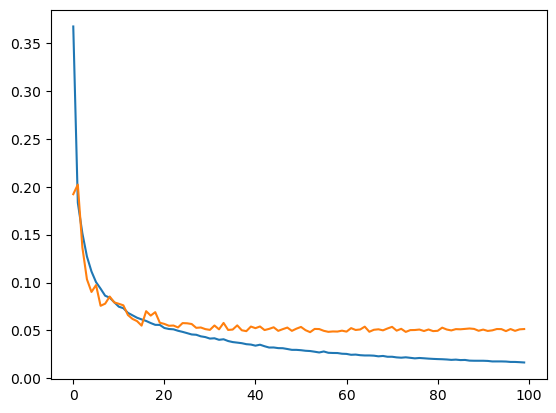

In [14]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [15]:
# save scaler
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
